# Query data from overpassAPI (openstreetmaps)


query now with Python by using the requests package in order to access the Overpass API

https://towardsdatascience.com/loading-data-from-openstreetmap-with-python-and-the-overpass-api-513882a27fd0

## Area[] Berlin 
area["ISO3166-2"="DE-BE"]
https://www.openstreetmap.org/relation/62422

## admin_level=4
admin_level=2 through admin_level=10 allow for different administrative subdivision schemes to be handled in a consistent way by data consumers. The use of a numbering scheme rather than words for the values helps avoid confusion due to different terminology used in different countries
A data consumer looking for municipalities corresponding to "city", "town" or "village" boundaries will find these tagged anywhere from admin_level=4 (e.g. relation Berlin)

In [15]:
import requests
import json

overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area["ISO3166-2"="DE-BE"][admin_level=4];
(node['shop'='convenience'](area);
 way['shop'='convenience' ](area);
 rel['shop'='convenience' ](area);
);
out center;
"""
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
data = response.json()

In [16]:
overpass_query

## Plotting 

In [311]:
import numpy as np
import matplotlib.pyplot as plt

# Collect coords into list
coords = []
for element in data['elements']:
  if element['type'] == 'node':
    lon = element['lon']
    lat = element['lat']
    coords.append((lon, lat))
  elif 'center' in element:
    lon = element['center']['lon']
    lat = element['center']['lat']
    coords.append((lon, lat))# Convert coordinates into numpy array
X = np.array(coords)

plt.plot(X[:, 0], X[:, 1], 'o')
plt.title('Spatkauf in Berlin')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.show()

NameError: name 'data' is not defined

# overpy package

In [15]:
import overpy

api = overpy.Overpass()

r = api.query("""
area["ISO3166-2"="DE-BE"][admin_level=4];
(node["amenity"="biergarten"](area);
 way["amenity"="biergarten"](area);
 rel["amenity"="biergarten"](area);
);
out center;
""")

coords  = []
coords += [(float(node.lon), float(node.lat)) 
           for node in r.nodes]
coords += [(float(way.center_lon), float(way.center_lat)) 
           for way in r.ways]
coords += [(float(rel.center_lon), float(rel.center_lat)) 
           for rel in r.relations]

In [17]:
r.__dict__

{'_areas': OrderedDict(),
 '_nodes': OrderedDict([(26865440,
               <overpy.Node id=26865440 lat=52.4333644 lon=13.1907340>),
              (27318009,
               <overpy.Node id=27318009 lat=52.4200885 lon=13.1763456>),
              (167013475,
               <overpy.Node id=167013475 lat=52.4916944 lon=13.4389954>),
              (255049657,
               <overpy.Node id=255049657 lat=52.4337259 lon=13.1642419>),
              (257708389,
               <overpy.Node id=257708389 lat=52.5406075 lon=13.2066054>),
              (276134997,
               <overpy.Node id=276134997 lat=52.4299830 lon=13.3540107>),
              (280589004,
               <overpy.Node id=280589004 lat=52.5976055 lon=13.2749705>),
              (297233488,
               <overpy.Node id=297233488 lat=52.5697896 lon=13.3942046>),
              (300327588,
               <overpy.Node id=300327588 lat=52.5422827 lon=13.2816533>),
              (388514302,
               <overpy.Node id=388514302 l

# get boundaries and outline of city

In [431]:
import requests
import json

country_name = 'Germany'
city_name = 'Berlin'

'''example'''
# area[name="Köln"]->.b;
# rel(area.b)[name="Innenstadt"];
# map_to_area -> .a;
# node(area.a)[amenity=pub];
# out meta;

'''not working'''
# study_area = f"""area[name='{country_name}']->.a;
#              rel(area.a)['boundary'='administrative'];
#              map_to_area -> .b;"""
# params = f"""area[name='{city_name}'](area.b);"""

'''not working'''
# study_area = f"""{{{{geocodeArea:{country_name}}}}}->.a;"""
# params = f"""area[name='{city_name}'](area.a);"""
# ['admin_level'='8']

study_area = f"""area['name:en'='{country_name}']->.a"""
params = f"""rel['name'='{city_name}'](area.a)"""

limit = ''
out_type = 'geom'

border_query = f"""{study_area};
                ({params};
                );
                out {limit} {out_type};
                """

In [432]:
print(border_query)

area['name:en'='Germany']->.a;
                (rel['name'='Berlin'](area.a);
                );
                out  geom;
                


In [433]:
api = overpy.Overpass()

overy_request = api.query(border_query)
overy_request

In [434]:
overy_request.__dict__

{'_areas': OrderedDict(),
 '_nodes': OrderedDict(),
 '_ways': OrderedDict(),
 '_relations': OrderedDict([(62422, <overpy.Relation id=62422>)]),
 '_class_collection_map': {overpy.Node: OrderedDict(),
  overpy.Way: OrderedDict(),
  overpy.Relation: OrderedDict([(62422, <overpy.Relation id=62422>)]),
  overpy.Area: OrderedDict()},
 'api': <overpy.Overpass at 0x7f9093304c70>}

In [435]:
overy_request.relations[0].__dict__

{'_result': <overpy.Result at 0x7f9093304820>,
 'attributes': {},
 'id': 62422,
 'tags': {'ISO3166-2': 'DE-BE',
  'TMC:cid_58:tabcd_1:Class': 'Area',
  'TMC:cid_58:tabcd_1:LCLversion': '12.0',
  'TMC:cid_58:tabcd_1:LocationCode': '266',
  'admin_level': '4',
  'alt_name:vi': 'Béc-lin',
  'boundary': 'administrative',
  'contact:facebook': 'http://www.facebook.com/Berlin',
  'contact:website': 'http://www.berlin.de',
  'de:amtlicher_gemeindeschluessel': '11000000',
  'de:place': 'city',
  'de:regionalschluessel': '110000000000',
  'geographical_region': 'Barnim;Berliner Urstromtal;Teltow;Nauener Platte',
  'license_plate_code': 'B',
  'name': 'Berlin',
  'name:af': 'Berlyn',
  'name:als': 'Berlin',
  'name:am': 'በርሊን',
  'name:an': 'Berlín',
  'name:ang': 'Berlin',
  'name:ar': 'برلين',
  'name:arc': 'ܒܪܠܝܢ',
  'name:ast': 'Berlín',
  'name:az': 'Berlin',
  'name:ba': 'Берлин',
  'name:bar': 'Berlin',
  'name:bat-smg': 'Berlīns',
  'name:be': 'Берлін',
  'name:be-tarask': 'Бэрлін',
  'n

In [436]:
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = f"""
                [out:json][timeout:25];
                {study_area};
                {params};
                out {limit} {out_type};
                """
response = requests.get(overpass_url, 
                            params={'data': overpass_query})
res = response.json()

In [438]:
id_city = res['elements'][0]['id']

In [444]:
res['elements'][0]['bounds']

{'minlat': 52.3382448,
 'minlon': 13.088345,
 'maxlat': 52.6755087,
 'maxlon': 13.7611609}

# shapely boundary

In [517]:
import shapely.geometry as geometry
from shapely.ops import linemerge, unary_union, polygonize


query = f"""[out:json][timeout:25];
rel({id_city});
out body;
>;
out skel qt; """
api = overpy.Overpass()
result = api.query(query)

lss = []  #convert ways to linstrings

for ii_w, way in enumerate(result.ways):
    ls_coords = []

    for node in way.nodes:
        ls_coords.append(
            (node.lon, node.lat))  # create a list of node coordinates

    lss.append(
        geometry.LineString(ls_coords))  # create a LineString from coords

merged = linemerge([*lss])  # merge LineStrings
borders = unary_union(merged)  # linestrings to a MultiLineString
polygons = list(polygonize(borders))
city = geometry.MultiPolygon(polygons)

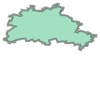

In [518]:
city


## params function

In [ ]:
#not working
# def param_key(keys):
    
#     #params defining the whole key example 'leisure' 
# #     get every type of leisure instalation, as a list returns several keys
    
#     string_keys = ''
#     for k in keys: 
#         string_keys += f"""node[{k}](area);"""
#     return string_keys

# def param_key_value(key, value):
    
#     #params defining the key and value, example 'leisure' 'parks' will only get parks
    
#     string_key = f"""\
#     node['{key}'='{value}'](area);
#     way['{key}'='{value}'](area);
#     rel['{key}'='{value}'](area);
#     """
#     return string_key

## imports

In [467]:
import requests
import json

In [468]:
#style working properly
# osm_keys_ok = """node["amenity"="pub"](area.berlin);
#             node["amenity"="bar"](area.berlin); 
#             """

## query function

In [491]:
overpass_url = "http://overpass-api.de/api/interpreter"

# study_area = 'area["ISO3166-2"="DE-BE"]->.berlin'
study_area = f"""area(62422)->.bound"""

out_type = 'body qt'

keys_values_osm = {'amenity':['bbq','drinking_water']}


def param_nodes(keys):
    '''converts the dict into a string, returns a str'''
    osm_keys = ''
    for k,val in keys.items():
        for v in val:
            osm_keys += f"""node['{k}'='{v}'](area.bound);"""
    return osm_keys
    
def param_ways(keys):
    '''converts the dict into a string, returns a str'''
    osm_keys = ''
    for k,val in keys.items():
        for v in val:
            osm_keys += f"""way['{k}'='{v}'](area.bound);"""
    return osm_keys

def param_areas(keys):
    '''converts the dict into a string, returns a str'''
    osm_keys = ''
    for k,val in keys.items():
        for v in val:
            osm_keys += f"""area['{k}'='{v}'](area.bound);"""
    return osm_keys


def query_params_osm(keys, feat, limit=''):
    '''Adding keys and values as a dictionary, example: keys_values_osm = {'amenity':['bbq','cafe']}
    several values can added to a same key as a list, returns a dict
    feat = nodes, ways or areas (geometry type)
    limit = number (optional query limit)'''
    
    if feat == 'ways':
        params = param_ways(keys)
        out_type = 'geom'
    if feat == 'areas':
        params = param_areas(keys)
        out_type = 'geom'
    if feat == 'nodes':
        params = param_nodes(keys)
        out_type = 'center'
        
    overpass_query = f"""[out:json][timeout:25];{study_area};({params});
                        out {limit} {out_type};
                    """
    response = requests.get(overpass_url, 
                            params={'data': overpass_query})
    return response.json(),

In [497]:
from geopy.geocoders import Nominatim
import overpy

city_name = "berlin"

# Geocoding request via Nominatim
geolocator = Nominatim(user_agent="city_compare")
geo_results = geolocator.geocode(city_name, exactly_one=False, limit=3)

# Searching for relation in result set
for r in geo_results:
    print(r.address, r.raw.get("osm_type"))
    if r.raw.get("osm_type") == "relation":
        city = r
        break

# Calculating area id
area_id = int(city.raw.get("osm_id")) + 3600000000

# Excecuting overpass call
api = overpy.Overpass()
result = api.query("""
    area(%s)->.searchArea;
    (
      node["amenity"="pub"](area.searchArea);
      way["amenity"="pub"](area.searchArea);
      relation["amenity"="pub"](area.searchArea);
    );
    out body;
    """ % area_id)

# Printing no. of pubs in nodes and ways
print("Amenities in nodes: %d" % len(result.nodes))
print("Amenities in ways: %d" % len(result.ways))

Berlin, Deutschland relation
Amenities in nodes: 1000
Amenities in ways: 20


In [498]:
result.nodes

[<overpy.Node id=35300986 lat=52.5398463 lon=13.3521465>,
 <overpy.Node id=78447148 lat=52.5698075 lon=13.3101301>,
 <overpy.Node id=84904956 lat=52.5712131 lon=13.3134197>,
 <overpy.Node id=89274696 lat=52.5235991 lon=13.4109696>,
 <overpy.Node id=89957618 lat=52.5840688 lon=13.3025780>,
 <overpy.Node id=137549003 lat=52.5699596 lon=13.3138632>,
 <overpy.Node id=137549008 lat=52.5708788 lon=13.3158208>,
 <overpy.Node id=137549010 lat=52.5688285 lon=13.3170085>,
 <overpy.Node id=137549024 lat=52.5700374 lon=13.3221149>,
 <overpy.Node id=139671037 lat=52.5342924 lon=13.1421398>,
 <overpy.Node id=140274896 lat=52.5682701 lon=13.3678890>,
 <overpy.Node id=140274903 lat=52.5754322 lon=13.3303066>,
 <overpy.Node id=150667269 lat=52.5431648 lon=13.3566864>,
 <overpy.Node id=150989193 lat=52.5642761 lon=13.3265108>,
 <overpy.Node id=150990860 lat=52.5235968 lon=13.3007288>,
 <overpy.Node id=175685782 lat=52.5965582 lon=13.3330486>,
 <overpy.Node id=186054004 lat=52.5726395 lon=13.3048085>,
 <

In [492]:
keys_values_osm

{'amenity': ['bbq', 'drinking_water']}

In [493]:
param_nodes(keys_values_osm)

"node['amenity'='bbq'](area.bound);node['amenity'='drinking_water'](area.bound);"

In [494]:
data = query_params_osm(keys_values_osm, feat='nodes')

In [495]:
data

({'version': 0.6,
  'generator': 'Overpass API 0.7.58.2 2b5354b1',
  'osm3s': {'timestamp_osm_base': '2022-06-03T14:05:17Z',
   'timestamp_areas_base': '2022-06-03T13:41:40Z',
   'copyright': 'The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.'},
  'elements': []},)

In [364]:
len(data['elements'])

TypeError: tuple indices must be integers or slices, not str

# Params for Mobility

## Get dict for public transport

nodes

In [ ]:
public_transport = {'amenity':['bus_station'],
                    'bus_bay':'',
                   'highway':['bus_stop','platform'],
                   'public_transport':['stop_position','platform','station','stop_area'],
                   'railway':['station','tram_stop', 'subway_entrance']}

bike_infraestructure =  {'amenity':['bicycle_parking', 'bicycle_repair_station', 'bicycle_rental']}

In [ ]:
param_nodes(public_transport)

In [ ]:
query_publictransport = query_params_osm(public_transport, 'nodes')
query_bikeinfraestructure = query_params_osm(bike_infraestructure, 'nodes')

## Get dict for Cyclelanes and pedestrians

Ways queries

In [39]:
cycle_paths = {'bicycle':['designated']}
# 'highway':['cycleway']

In [40]:
param_ways(cycle_paths)

"way['bicycle'='designated'](area.berlin);"

In [47]:
data_cycle = query_params_osm(cycle_paths, feat='ways')

In [48]:
len(data_cycle['elements'])

0

# Params for Social Life

nodes

In [ ]:
eating = {'amenity':['cafe','restaurant', 'food_court', 'ice_cream']}

night_life = { 'amenity':['bar','pub','biergarten', 'nightclub', 'swingerclub', 'casino']}

culture = {'amenity':['social_centre','theatre','public_bookcase',
                      'fountain', 'events_venue', 'community_centre', 'cinema', 
                      'arts_centre', 'conference_centre']}

community = {'office': ['association','charity', 'coworking', 
                        'educational_institution', 'employment_agency', 'foundation', 
                        'ngo', ; 'political_party', 'research']}

# Params for Activities


nodes

In [ ]:
health_care = {'amenity':['baby_hatch','clinic','dentist',
                      'doctors', 'hospital', 'nursing_home', 'pharmacy', 
                      'social_facility', 'veterinary']}

public_service = {'amenity':['courthouse','fire_station','police',
                      'post_box', 'post_office', 'townhall']}

education = {'amenity':['college','kindergarten','language_school',
                      'library', 'music_school', 'school', 'university']}

economic = {'amenity':['atm', 'bank', 'bureau_de_change']}

#  Params for Comfort

## Node Queries

In [ ]:
comfort_spots = {'amenity':['bbq','bench','dog_toilet',
                      '	drinking_water', 'give_box', 'shelter', 'shower', 
                      'toilets', 'water_point', 'watering_place']}

leisure_spots = {'leisure':['bandstand','bird_hide','dog_park',
                      'firepit', 'swimming_pool', 'stadium', 'sports_centre', 
                      'pitch', 'picnic_table', 'fitness_centre'],
                 'historic':''}

trees = []


## Area querys

In [49]:
leirsure_areas = {'leisure':['park','garden','swimming_area',
                      'playground', 'nature_reserve', 'marina'],
                 'landuse':['forest']}

# test of geometries query 

In [50]:
test = {'amenity':['bbq']}

In [56]:
leisure = query_params_osm(leirsure_areas, 'areas',10)

In [57]:
len(leisure['elements'])

10

In [58]:
leisure

{'version': 0.6,
 'generator': 'Overpass API 0.7.58.1 bb9ccb2d',
 'osm3s': {'timestamp_osm_base': '2022-06-01T11:22:02Z',
  'timestamp_areas_base': '2022-06-01T11:19:04Z',
  'copyright': 'The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.'},
 'elements': [{'type': 'way',
   'id': 4317997,
   'bounds': {'minlat': 52.4361223,
    'minlon': 13.1991992,
    'maxlat': 52.4463904,
    'maxlon': 13.2281429},
   'nodes': [3444570611,
    3444570612,
    7685956388,
    1641536697,
    7004674381,
    1641536696,
    7004674380,
    3807067428,
    7004718361,
    26201852,
    7004674379,
    7004674378,
    7004718360,
    26201851,
    7004718359,
    7004674377,
    26201850,
    26201849,
    1641536710,
    7004718358,
    1641536704,
    7004674376,
    7004718357,
    7004674375,
    26201846,
    26201845,
    7004718356,
    7004674374,
    30206023,
    7004718355,
    1641536687,
    7004718354,
    1641536684,
    7004718353,
  

In [63]:
import pandas as pd
import numpy as np

In [68]:
def osm_json_to_DF(response):
    response_elements = response['elements']
    elements_tmp = []

    for element in response_elements:
        elements_tmp.append(element['geometry'])

    return pd.DataFrame({'Coords':elements_tmp})

In [69]:
df1 = osm_json_to_DF(leisure)

In [70]:
df1

,Coords
0,"[{'lat': 52.444682, 'lon': 13.2280998}, {'lat'..."
1,"[{'lat': 52.4938425, 'lon': 13.3108972}, {'lat..."
2,"[{'lat': 52.3988901, 'lon': 13.3929865}, {'lat..."
3,"[{'lat': 52.4517866, 'lon': 13.2334826}, {'lat..."
4,"[{'lat': 52.4839088, 'lon': 13.3086236}, {'lat..."
5,"[{'lat': 52.4840395, 'lon': 13.3198242}, {'lat..."
6,"[{'lat': 52.5258436, 'lon': 13.3390141}, {'lat..."
7,"[{'lat': 52.5476389, 'lon': 13.3836015}, {'lat..."
8,"[{'lat': 52.5032558, 'lon': 13.3773207}, {'lat..."
9,"[{'lat': 52.4867775, 'lon': 13.3807694}, {'lat..."


## converting to csv

In [71]:
df1.to_csv('../livablestreets/data/areas_test.csv', index=False)